In [1]:
# Ensure required packages are installed (will try only if imports fail)
import importlib, subprocess, sys
def ensure(pkg_name, import_name=None):
    import_name = import_name or pkg_name
    try:
        importlib.import_module(import_name)
    except Exception:
        print(f'Installing {pkg_name}...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg_name])

# core packages
for p in ('pandas','numpy','scikit-learn','joblib','matplotlib'):
    ensure(p)
# optional explainability packages
ensure('shap')
# ensure project package imports (local package files are in ../backend-python/grracing)
# No pip install required for local package — ensure notebook server is started from project root or sys.path adjusted below
import os, sys
proj_root = os.path.abspath(os.path.join('..'))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)
print('Setup complete')

C:\Users\SR\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\SR\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Installing scikit-learn...
Setup complete
Setup complete


In [2]:
# Imports
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
import shap
# Import helper preprocess and models from the backend-python package
import importlib
# assume the notebook is in gr-race-guardian/notebooks and backend-python is one level up
backend_pkg_path = os.path.abspath(os.path.join('..', 'backend-python'))
if backend_pkg_path not in sys.path:
    sys.path.insert(0, backend_pkg_path)
from grracing.preprocess import merge_lap_and_telemetry
from grracing.models import train_simple_model, load_model_meta
print('Imports ready')

Imports ready


In [3]:
# Paths to sample data in the workspace — adjust if your layout differs
root = os.path.abspath(os.path.join('..'))
lap_csv = os.path.join(root, 'road-america', 'road-america', 'Road America', 'Race 1', 'road_america_lap_time_R1.csv')
telemetry_csv = os.path.join(root, 'road-america', 'road-america', 'Road America', 'Race 1', 'R1_road_america_telemetry_data.csv')
print('Lap CSV exists?', os.path.exists(lap_csv))
print('Telemetry CSV exists?', os.path.exists(telemetry_csv))
# Produce a merged CSV using our preprocess helper (this will create an aggregated features CSV)
merged_out = os.path.join('..', 'backend-python', 'models', 'merged_road_america.csv')
os.makedirs(os.path.dirname(merged_out), exist_ok=True)
merged_df = merge_lap_and_telemetry(lap_csv, telemetry_csv, out_csv=merged_out)
print('Merged rows:', len(merged_df))
merged_df.head()

Lap CSV exists? True
Telemetry CSV exists? True
Merged rows: 221
Merged rows: 221


,expire_at,lap,meta_event,meta_session,meta_source,meta_time,outing,timestamp,value,vehicle_id,expire_at_mean,expire_at_max,lap_mean,lap_max,outing_mean,outing_max,telemetry_value_mean,telemetry_value_max,vehicle_number_mean,vehicle_number_max
0,NaN,32768,I_R05_2025-08-17,R1,kafka:gr-raw,2025-08-16T19:16:11.729Z,0,2025-08-16T19:16:10.678Z,1041902,GR86-022-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,32768,I_R05_2025-08-17,R1,kafka:gr-raw,2025-08-16T19:16:23.751Z,0,2025-08-16T19:16:14.490Z,2588041,GR86-047-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,32768,I_R05_2025-08-17,R1,kafka:gr-raw,2025-08-16T19:16:23.969Z,0,2025-08-16T19:16:18.336Z,3079666,GR86-063-113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,32768,I_R05_2025-08-17,R1,kafka:gr-raw,2025-08-16T19:16:36.617Z,0,2025-08-16T19:16:36.072Z,268481,GR86-035-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,32768,I_R05_2025-08-17,R1,kafka:gr-raw,2025-08-16T19:16:48.916Z,0,2025-08-16T19:16:46.393Z,2277387,GR86-013-80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Basic feature selection and training using train_simple_model to preserve metadata
from grracing.models import train_simple_model
df = pd.read_csv(merged_out)
# choose numeric columns and pick 'value' as target if present (common in lap_time files)
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
print('Numeric cols:', numeric_cols)
if 'value' in df.columns:
    target = 'value'
else:
    target = numeric_cols[-1] if numeric_cols else None
features = [c for c in numeric_cols if c != target]
if not features:
    df['idx_feat'] = df.index
    features = ['idx_feat']
print('Training target:', target)
# Save model into backend-python/models so the notebook and helper scripts agree on path
model_out = os.path.join('..', 'backend-python', 'models', 'merged_road_model.joblib')
os.makedirs(os.path.dirname(model_out), exist_ok=True)
model = train_simple_model(df, features, target, out_path=model_out)
print('Model saved to', model_out)

Numeric cols: ['expire_at', 'lap', 'outing', 'value', 'expire_at_mean', 'expire_at_max', 'lap_mean', 'lap_max', 'outing_mean', 'outing_max', 'telemetry_value_mean', 'telemetry_value_max', 'vehicle_number_mean', 'vehicle_number_max']
Training target: value
Model saved to models\merged_road_model.joblib


Features used for SHAP: ['expire_at', 'lap', 'outing', 'expire_at_mean', 'expire_at_max', 'lap_mean', 'lap_max', 'outing_mean', 'outing_max', 'telemetry_value_mean', 'telemetry_value_max', 'vehicle_number_mean', 'vehicle_number_max']
Saved SHAP summary to ..\backend-python\models\shap_summary.png
Saved SHAP summary to ..\backend-python\models\shap_summary.png


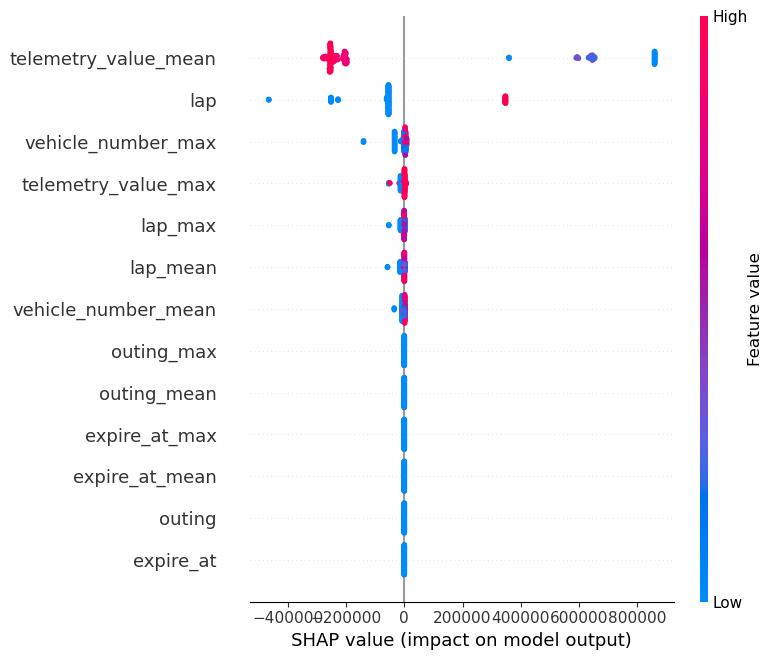

In [5]:
# Load model and display SHAP explanations (TreeExplainer for tree-based models)
model = joblib.load(model_out)
meta = load_model_meta(model_out)
features_used = meta['feature_names'] if meta else features
print('Features used for SHAP:', features_used)
# prepare a small sample X for SHAP (use 100 rows or less to keep compute light)
sample_X = df[features_used].fillna(0).values[:200]
explainer = shap.Explainer(model)
# compute shap values (use a small sample to keep runtime reasonable)
shap_values = explainer(sample_X)
# Summary plot
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, features=sample_X, feature_names=features_used, show=False)
plt.tight_layout()
out_png = os.path.join('..', 'backend-python', 'models', 'shap_summary.png')
plt.savefig(out_png)
print('Saved SHAP summary to', out_png)

In [ ]:
# Display the saved SHAP image inline
from IPython.display import Image, display
img_path = os.path.join('..', 'backend-python', 'models', 'shap_summary.png')
print('SHAP image path:', img_path)
display(Image(filename=img_path))

### Embedded SHAP summary image
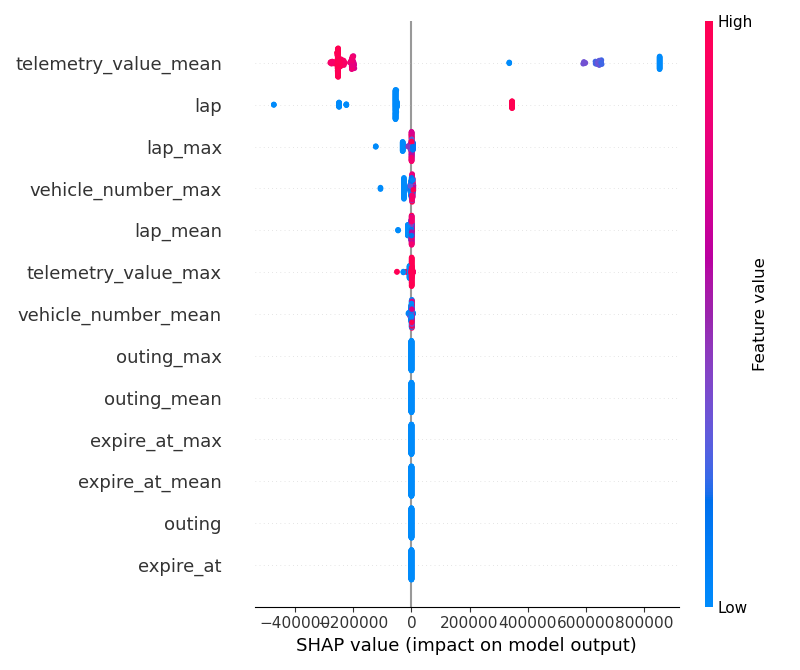

**Next steps / Notes**
- If any imports fail (particularly `shap` or `uvicorn`), re-run the first cell to install them or install in your environment before running the notebook.
- For production use: expand preprocessing in `grracing.preprocess` to include lap classification (OUT/HOT/IN/PIT), sector joins, tyre compound and stint indexing, and time-windowed traffic features.
- To run this notebook in Docker, build the images with `docker-compose up --build` and open a Jupyter server inside the Python container (I can add a Jupyter service to the compose file if you want that).